I am using a polytropic equation of state, which is defined as

$$ P(\varepsilon) = \Kappa\varepsilon^\gamma  $$

Since I'm using scaled units, the equation actually is written in the form

$$ P'(\varepsilon') = K\varepsilon'^{\gamma} $$

Here are the steps to transform the first equation into the second one.

These are the TOV equations.

$$
\frac{dm_r}{dr} = 4\pi r^2 \varepsilon(r)
$$

$$
\frac{dP}{dr}=
    -G\frac{m_r(r)\varepsilon(r)}{r^2}
    \left(1+\frac{P(r)}{\varepsilon(r)}\right)
    \left(1+\frac{4\pi r^3 P(r)}{m_r(r)}\right)
    \left(1-\frac{2 Gm_r(r)}{r}\right)^{-1}
$$

$r$ = radius (km).

$m_r(r)$ = the radius enclosed within a radius $r$ in ($M_\odot$).

$P(r)$ = the pressure at radius $r$ (_MeV/fm<sup>3</sup>_).

$\varepsilon(r)$ = energy density at radius $r$ (_MeV/fm<sup>3</sup>_).

$G$ = gravitational constant.



I'm going to start by using the dimensionless TOV equations.

$$
\frac{dP'}{dr'}=
    \left(-\frac{m_r' e'}{r'^2} \right)
    \left(1 + \frac{P'}{\varepsilon} \right)
    \left(1 + \frac{4\pi r'^3 P'}{m_r'} \right)
    \left(1 - \frac{2m_r'}{r'} \right)^{-1}
$$

Where a quantity being primed denotes that it is a unitless value being scaled by a constant with the units of energy density, $\varepsilon_0$. For example, $P = \varepsilon_0 P'$ (also meaning that $P' = \frac{P}{\varepsilon_0}$). To convert back to the original units, I can use the equations

$$ m_r = \frac{m_r'}{(G^3 \varepsilon_0)^\frac{1}{2}} $$

$$ r = \frac{r'}{(G\varepsilon_0)^\frac{1}{2}} $$

In [43]:
from dataclasses import dataclass
import numpy as np
from scipy.constants import pi, G
from scipy.integrate import solve_ivp

@dataclass
class MassRadiusSolutions:
    '''
    An object for encapsulating the solutions for a mass-radius curve.
    '''
    r_solutions: list[float]
    m_solutions: list[float]

    def from_solve_ivp(solutions):
        return MassRadiusSolutions(
            r_solutions=convert_radius_to_nu(solutions.t),
            m_solutions=convert_mass_to_nu(solutions.y[1])
        )

# Scaling constant
E_0 = 1e34

def energy_density(P_prime):
    '''
    Calculates the energy density as a function of P'.
    '''
    gamma = 2.0
    K = 1.0
    K_prime = K * (E_0 ** (gamma - 1))
    return (P_prime / K_prime)**(1/gamma)

def scaled_tov_rhs(r, state):
    '''
    Returns [dP/dr, dm/dr] using a TOV equation scaled by an energy density constant. Treat every 
    value with a unit as being dimensionless.
    '''
    # Pressure, mass, and density at the current radius
    P_r, m_r = state
    if P_r <= 0:
        return [0, 0]
    e_r = energy_density(P_r)
    # Mass 
    dm_dr = 4*pi * r**2 * e_r
    # Pressure (split into factors)
    f1 = -(m_r * e_r) / (r ** 2)
    f2 = 1 + (P_r / e_r)
    f3 = 1 + ((4*pi * (r**3) * P_r) / m_r)
    f4 = (1 - (2 * m_r / r)) ** -1
    dp_dr = f1 * f2 * f3 * f4
    return [dp_dr, dm_dr]

def pressure_boundary_event(r, state):
    '''
    Event for solve_ivp() that returns 0 when the pressure is 0,
    indicating that the edge fo the star has been reached.
    '''
    p, _ = state
    return 0 if p <= 0 else 1

# Cancel solve_ivp() when radius reaches boundary.
pressure_boundary_event.terminal = True
# Only trigger event when going from psoitive to negative
pressure_boundary_event.direction = -1

@np.vectorize
def convert_pressure_to_scaled(P):
    '''
    Returns the scaled pressure where `P` is in natural units.
    '''
    return P / E_0

def convert_radius_to_scaled(r):
    '''
    Returns the scaled radius where `r` is in natural units.
    '''
    return r * ((G * E_0) ** 1/2)

@np.vectorize
def convert_mass_to_nu(m_prime):
    '''
    Returns the mass in natural units (solar masses) where `m_prime` is the scaled value.
    '''
    M_SUN = 1.98847e30
    mass_kg = m_prime / ((G**3 * E_0)**(1/2))
    return mass_kg / M_SUN

@np.vectorize
def convert_radius_to_nu(r_prime):
    '''
    Returns the radius in natural units (km) where `r_prime` is the scaled value.
    '''
    radius_meters = r_prime / ((G * E_0)**(1/2)) 
    return radius_meters / 1000

def small_r_expansion(r_0, P_c):
    return ((4*pi)/3) * r_0**3 * energy_density(P_c)

# Starting radius
R_START = 1e-6
# Maximum possible radius. solve_ivp() shoud terminate before reaching this value.
R_END = 100
# Central pressure.
P_C = 10**2
# Central enclosed mass.
M_0 = small_r_expansion(R_START, P_C) # Solar Masses

def solve() -> MassRadiusSolutions:
    '''
    Use solve_ivp() to find solutions using the scaled TOV equations. Then, the results are rescaled
    and added to a `MassRadiusSolutions` object.
    '''
    solutions = solve_ivp(
        scaled_tov_rhs,
        t_span=(R_START, R_END),
        y0=(P_C, M_0),
        events=pressure_boundary_event
    )
    solutions = MassRadiusSolutions.from_solve_ivp(solutions)
    return solutions

solutions = solve()
print(f"Radius Solutions: {solutions.r_solutions}")
print(f"Mass Solutions: {solutions.m_solutions}")

Radius Solutions: [1.22404431e-21 3.16098019e-17 7.14810223e-17 1.03482832e-16
 1.35484642e-16 1.77725610e-16 2.29419549e-16 2.93797762e-16
 3.74515881e-16 4.76112332e-16 6.04276564e-16 7.66178514e-16
 9.70877195e-16 1.22983754e-15 1.55759038e-15 1.97258285e-15
 2.49828691e-15 3.16466836e-15 4.01017883e-15 5.08454138e-15
 6.45279646e-15 8.20142956e-15 1.04480283e-14 1.33569807e-14
 1.71654448e-14 2.22264846e-14 2.90802695e-14 3.85693307e-14
 5.20134240e-14 7.14211048e-14 9.95973480e-14 1.22404431e-13]
Mass Solutions: [3.86332265e-66 5.96898709e-53 5.22769649e-52 1.27890257e-51
 2.37404208e-51 4.32834198e-51 7.49568525e-51 1.26202875e-50
 2.08814265e-50 3.41689856e-50 5.55113526e-50 8.97623108e-50
 1.44702962e-49 2.32811174e-49 3.74106667e-49 6.00735163e-49
 9.64378903e-49 1.54829780e-48 2.48705054e-48 3.99918296e-48
 6.44236831e-48 1.04087254e-47 1.68949622e-47 2.76180790e-47
 4.56266760e-47 7.65369339e-47 1.31138171e-46 2.31106918e-46
 4.21971044e-46 8.03246514e-46 1.60911877e-45 2.42

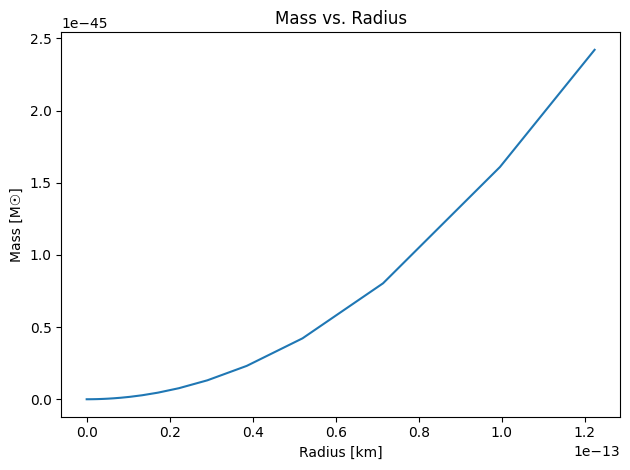

In [44]:
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import matplotlib.pyplot as plt

# The graphs here aren't useful because they aren't using realistic values.

subplots: tuple[Figure, Axes] = plt.subplots()
fig, ax = subplots

ax.set_title("Mass vs. Radius")
ax.set_ylabel("Mass [M☉]")
ax.set_xlabel("Radius [km]")
ax.plot(solutions.r_solutions, solutions.m_solutions)

fig.tight_layout()
plt.show()